In [11]:
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Lambda
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras import metrics
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import Counter

In [12]:
data = np.load('../data/fluxes_ecoli_biomass.npy')
data_no_nan = np.nan_to_num(x=data)
data.shape

(1258, 41, 2586)

In [13]:
flat_data = np.reshape(data_no_nan, (data.shape[0] * data.shape[1], data.shape[2]))

In [14]:
y = np.array(range(41) * data.shape[0])
y.shape

(51578,)

In [15]:
np.random.seed(seed=42)
train_ind = np.random.choice(flat_data.shape[0], size=int(0.9 * flat_data.shape[0]), replace=False)
test_ind = list(set(range(flat_data.shape[0])) - set(train_ind))

In [16]:
X_train, y_train = flat_data[train_ind], y[train_ind]
X_test, y_test = flat_data[test_ind], y[test_ind]

In [113]:
def build_ae(X_shape):
    encoding_sz = 100
    input_lay = Input(shape=(X_shape,))
    encoded = Dense(2 * encoding_sz, activation='relu')(input_lay)
    encoded = Dense(encoding_sz, activation='relu')(encoded)

    decoded = Dense(2 * encoding_sz, activation='relu')(encoded)
    decoded = Dense(X_shape, activation='sigmoid')(decoded)
    
    ae = Model(input_lay, decoded)
    encoder = Model(input_lay, encoded)
    encoded_input = Input(shape=(2 * encoding_sz,))
    decoder_layer = ae.layers[-1]
    decoder = Model(encoded_input, decoder_layer(encoded_input))
    
    ae.compile(optimizer='adadelta', loss='mean_squared_error')
    return ae, encoder, decoder

In [114]:
autoencoder, encoder, decoder = build_ae(X_train.shape[1])
autoencoder.fit(X_train, X_train,
                epochs=30,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))

encoded_fluxes = encoder.predict(X_test)
decoded_fluxes = decoder.predict(encoded_fluxes)

Train on 2952 samples, validate on 328 samples
Epoch 1/30
2952/2952 [==============================] - 1s 481us/step - loss: 486.6683 - val_loss: 489.7078
Epoch 2/30
2952/2952 [==============================] - 1s 334us/step - loss: 486.1105 - val_loss: 489.6810
Epoch 3/30
2952/2952 [==============================] - 1s 328us/step - loss: 486.0915 - val_loss: 489.6678
Epoch 4/30
2952/2952 [==============================] - 1s 340us/step - loss: 486.0829 - val_loss: 489.6622
Epoch 5/30
2952/2952 [==============================] - 1s 354us/step - loss: 486.0741 - val_loss: 489.6449
Epoch 6/30
2952/2952 [==============================] - 1s 382us/step - loss: 486.0601 - val_loss: 489.6388
Epoch 7/30
2952/2952 [==============================] - 1s 375us/step - loss: 486.0543 - val_loss: 489.6335
Epoch 8/30
2952/2952 [==============================] - 1s 379us/step - loss: 486.0505 - val_loss: 489.6312
Epoch 9/30
2952/2952 [==============================] - 1s 369us/step - loss: 486.0473 - 

ValueError: Error when checking : expected input_13 to have shape (200,) but got array with shape (100,)

In [17]:
min_val = np.min(X_train)
max_val = np.max(X_train)
scale = lambda x: (x + min_val) / max_val

In [18]:
X_scale = scale(X_train)
X_test_scale = scale(X_test)

In [8]:
encoded_dim1 = 512
encoded_sz = 256
latent_dim = 2
epsilon_std = 1.0
X_shape = 2500
# Encoder network
x = Input(shape=(X_shape,))
h = Dense(encoded_dim1, activation='relu')(x)
h = Dense(encoded_sz, activation='relu')(h)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

# Sample points from latent space
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder network
decoder_h = Dense(encoded_sz, activation='relu')
decoder_h2 = Dense(encoded_dim1, activation='relu')
decoder_mean = Dense(X_shape, activation='sigmoid')
h_decoded = decoder_h(z)
h_decoded2 = decoder_h2(h_decoded)
x_decoded_mean = decoder_mean(h_decoded2)

# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

xent_loss = X_shape * metrics.mean_squared_error(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')

/Users/nlarusstone/.virtualenvs/mphil/lib/python2.7/site-packages/ipykernel_launcher.py:31: UserWarning: Output "dense_23" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_23" during training.


In [9]:
print xent_loss
print kl_loss
print vae_loss

Tensor("mul:0", shape=(?,), dtype=float32)
Tensor("mul_1:0", shape=(?,), dtype=float32)
Tensor("Mean_1:0", shape=(), dtype=float32)


In [5]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon


def build_vae(X_shape, batch_size=100):
    encoded_dim1 = 512
    encoded_sz = 256
    # Encoder network
    x = Input(shape=(X_shape,))
    h = Dense(encoded_dim1, activation='relu')(x)
    h = Dense(encoded_sz, activation='relu')(h)
    z_mean = Dense(latent_dim)(h)
    z_log_var = Dense(latent_dim)(h)
    
    # Sample points from latent space
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
    
    # Decoder network
    decoder_h = Dense(encoded_sz, activation='relu')
    decoder_h2 = Dense(encoded_dim1, activation='relu')
    decoder_mean = Dense(X_shape, activation='sigmoid')
    h_decoded = decoder_h(z)
    h_decoded2 = decoder_h2(h_decoded)
    x_decoded_mean = decoder_mean(h_decoded2)

    # end-to-end autoencoder
    vae = Model(x, x_decoded_mean)
    
    xent_loss = X_shape * metrics.mean_squared_error(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='rmsprop')
    #vae.summary()

    # encoder, from inputs to latent space
    encoder = Model(x, z_mean)

    # generator, from latent space to reconstructed inputs
    decoder_input = Input(shape=(latent_dim,))
    _h_decoded = decoder_h(decoder_input)
    _h_decoded2 = decoder_h2(_h_decoded)
    _x_decoded_mean = decoder_mean(_h_decoded2)
    generator = Model(decoder_input, _x_decoded_mean)
    return vae, encoder, generator

In [ ]:
%%debug
latent_dim = 2
batch_size = 256
epsilon_std = 1.0
vae, encoder, generator = build_vae(X_scale.shape[1], batch_size)
es = EarlyStopping(patience=2)
vae.fit(X_scale,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(X_test_scale, None),
        callbacks=[es])

NOTE: Enter 'c' at the ipdb>  prompt to continue execution.
> <string>(2)<module>()

Breakpoint 1 at /Users/nlarusstone/.virtualenvs/mphil/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:2519


/Users/nlarusstone/.virtualenvs/mphil/lib/python2.7/site-packages/ipykernel_launcher.py:36: UserWarning: Output "dense_37" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_37" during training.


> /Users/nlarusstone/.virtualenvs/mphil/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py(2519)gradients()
   2517         A gradients tensor.
   2518     """
1> 2519     return tf.gradients(loss, variables, colocate_gradients_with_ops=True)
   2520 
   2521 

<tf.Tensor 'loss_2/add:0' shape=() dtype=float32>
[<tf.Variable 'dense_31/kernel:0' shape=(2586, 512) dtype=float32_ref>, <tf.Variable 'dense_31/bias:0' shape=(512,) dtype=float32_ref>, <tf.Variable 'dense_32/kernel:0' shape=(512, 256) dtype=float32_ref>, <tf.Variable 'dense_32/bias:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'dense_33/kernel:0' shape=(256, 2) dtype=float32_ref>, <tf.Variable 'dense_33/bias:0' shape=(2,) dtype=float32_ref>, <tf.Variable 'dense_34/kernel:0' shape=(256, 2) dtype=float32_ref>, <tf.Variable 'dense_34/bias:0' shape=(2,) dtype=float32_ref>, <tf.Variable 'dense_35/kernel:0' shape=(2, 256) dtype=float32_ref>, <tf.Variable 'dense_35/bias:0' shape=(256,) dtype=float32_ref>, <tf.Variable 

In [251]:
x_test_encoded = encoder.predict(X_test_scale, batch_size=batch_size)

In [255]:
x_test_encoded

array([[1.3519378 , 0.19300622],
       [1.3510592 , 0.19346124],
       [1.3491874 , 0.1900816 ],
       ...,
       [1.3495486 , 0.19357616],
       [1.3504057 , 0.1865893 ],
       [1.3498018 , 0.19421595]], dtype=float32)

In [ ]:
def get_rct(df, rct, y_test):
    y_new = []
    for ind in y_test:
        y_new.append(df[rct][ind])
    return y_new
get_rct(df, 'Glucose', y_test)

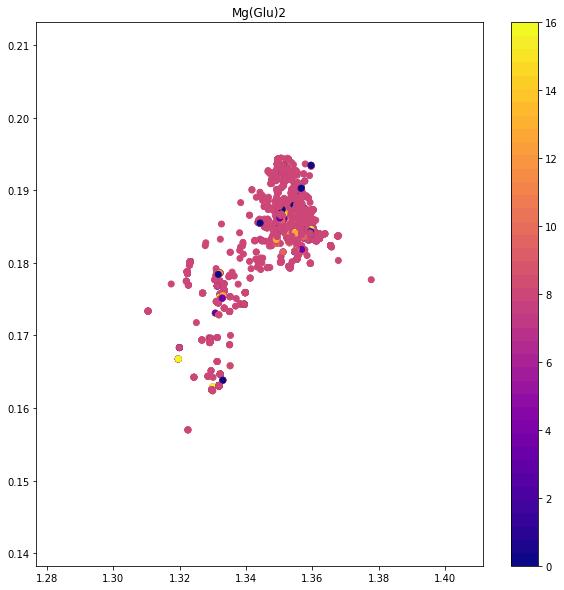

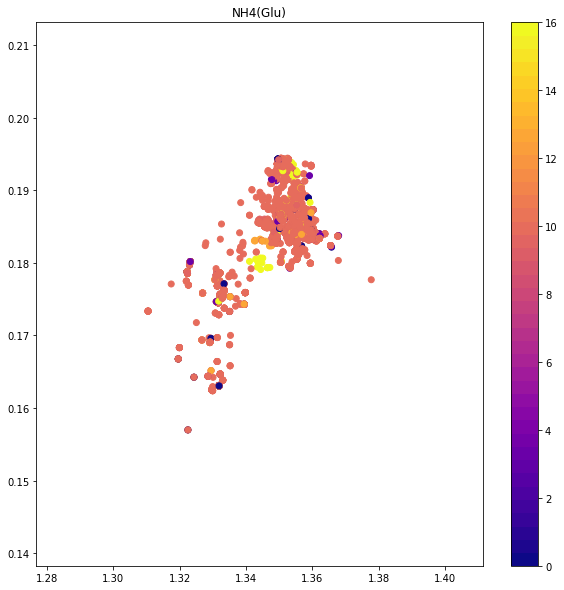

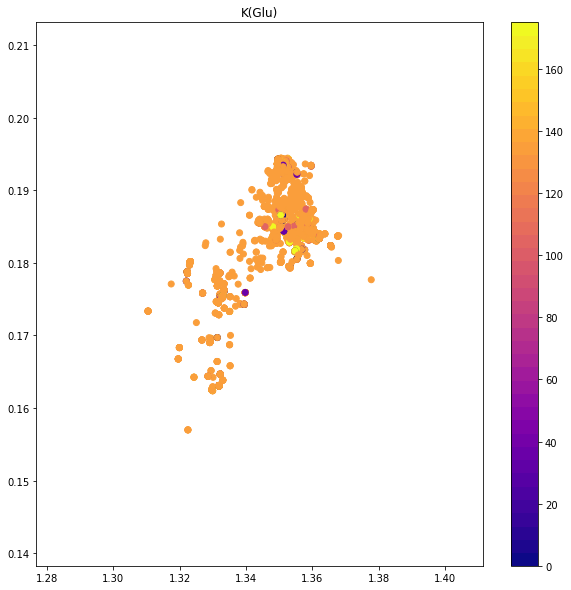

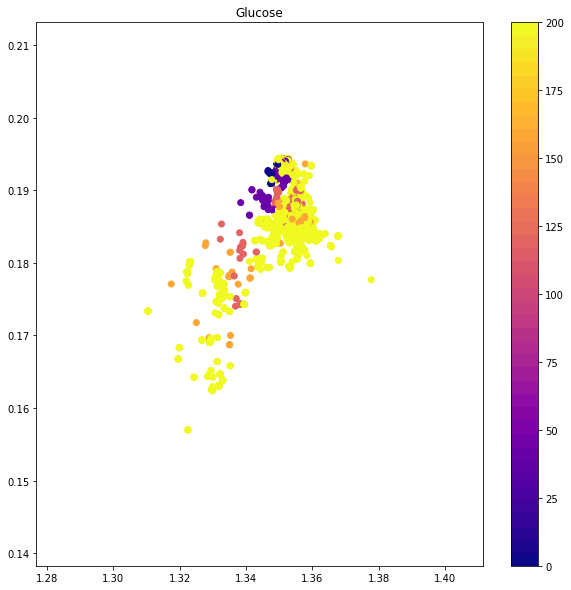

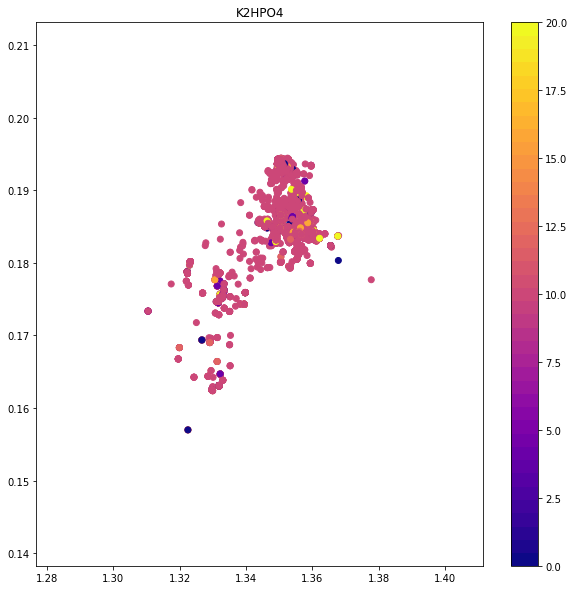

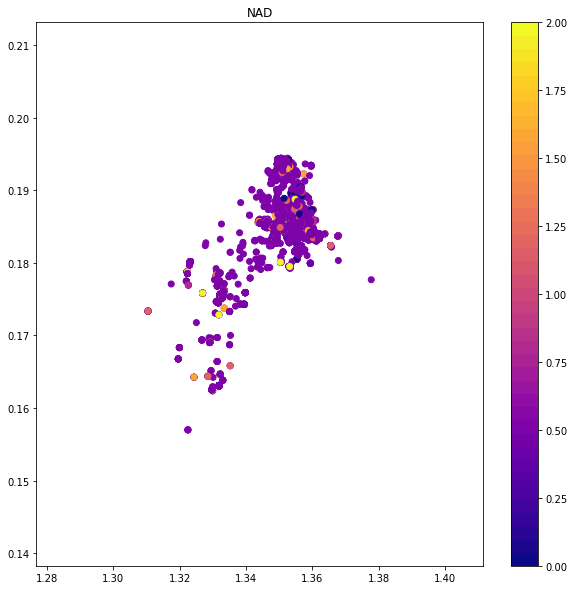

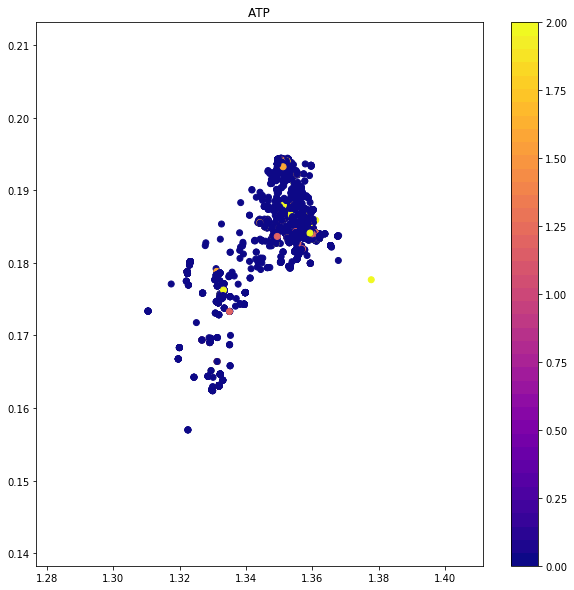

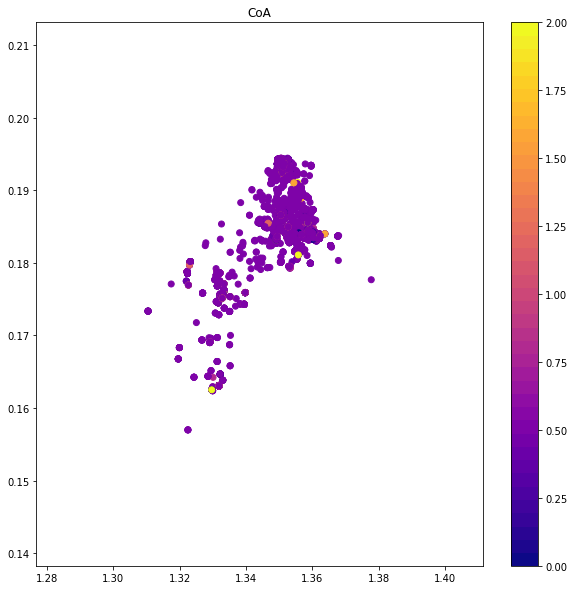

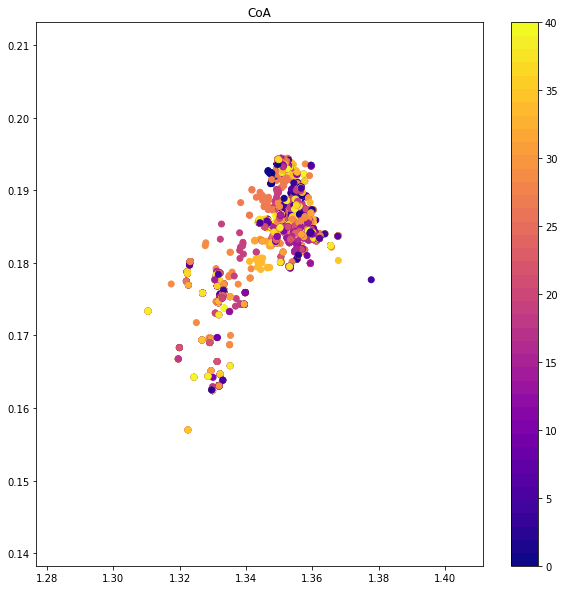

In [257]:
#cm1 = cm.get_cmap('tab20b', 20)
#cm2 = cm.get_cmap('tab20c', 20)
cmap = cm.get_cmap('plasma', 41)
#cmap = lambda x: cm1(x) if x < 21 else cm2(x)
xmin, xmax = np.amin(x_test_encoded[:, 0]), np.amax(x_test_encoded[:, 0])
ymin, ymax = np.amin(x_test_encoded[:, 1]), np.amax(x_test_encoded[:, 1])
x_diff = (xmax - xmin) / 2.0
y_diff = (ymax - ymin) / 2.0
for col in df.columns[4:]:
    plt.figure(figsize=(10, 10))
    plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=get_rct(df, col, y_test), cmap=cmap)
    plt.xlim((xmin - x_diff, xmax + x_diff))
    plt.ylim((ymin - y_diff, ymax + y_diff))
    plt.title(col)
    plt.colorbar()
    plt.show()
    
plt.figure(figsize=(10, 10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap=cmap)
plt.xlim((xmin - x_diff, xmax + x_diff))
plt.ylim((ymin - y_diff, ymax + y_diff))
plt.title('Variant')
plt.colorbar()
plt.show()

In [169]:
import pandas as pd
df = pd.read_csv('../data/Karim_MetEng_2018_Figure2_Data.csv')
df.drop(columns=['Area_1', 'Area_2', 'Conc_1', 'Conc_2'], inplace=True)
df.head()

,AVG,STD,AVG.1,STD.1,Mg(Glu)2,NH4(Glu),K(Glu),Glucose,K2HPO4,NAD,ATP,CoA
0,0.00,0.0,0.00,0.00,8.0,10.0,134,0,10,0.5,0.0,0.5
1,0.00,0.0,0.00,0.00,8.0,10.0,134,200,10,0.0,0.0,0.5
2,0.00,0.0,0.00,0.00,8.0,10.0,134,200,10,0.5,0.0,2.0
3,0.00,0.0,0.00,0.00,8.0,10.0,134,200,10,0.5,0.0,1.6
4,1.21,1.7,0.09,0.13,8.0,10.0,134,200,10,0.5,2.0,0.5


In [223]:
df.columns[3:]

Index([u'STD.1', u'Mg(Glu)2', u'NH4(Glu)', u'K(Glu)', u'Glucose', u'K2HPO4',
       u'NAD', u'ATP', u'CoA'],
      dtype='object')